As a guideline, study the greedy snake implementation by Trucco&Verri which is uploaded as a separate pdf file (snake-Trucco-Verri.pdf).

This project requires several components:

1. Computing a gradient magnitude image from your original image, a method which you have implemented in project 2.
2. A method to pick points in an image to create an initial polygon.
3. A core snake algorithm to calculate snake propagation based on internal and external forces.
4. Overlay of the polygon on the original image and/or the gradient magnitude external force image, show a few overlays from start to end to show propagation and to mimic a dynamic propagation in the report. 

Whereas the core algorithm (4) has to be implemented by yourself, the other components to use cursor clicking, drawing of polygon lines, and overlay of the evolving snake can make use of existing library functions.

The following procedure is suggested:
- Choose a small image and simple object to develop and test the procedure.
- Start developments with a polygon with limited number of points. 
- Consider a reasonable choice for the sigma of the Gaussian filter of the gradient magnitude external force. Would sigma be too small, a snake may not “feel” the external force to move towards the boundary, respectively the locations of the lowest external forces.
- The intensities of the gradient magnitude image need to be inverted to create dark minimum intensities at edges and larger intensities outside. It is suggested to change the [Min-Max] of the gradient magnitude to a range of [Max-Min] to stay in the positive intensity range.
- Reconsider the internal stretching force suggested by Trucco&Verri to keep the total length constant – this may impede the snake to contract. You may allow for some step-by-step shrinking.
- The parameters to combine the two internal with the external force are heuristic choices. It is suggested to write those forces into a table after each iteration, so that you may get a feeling on the magnitude of 
these energies accumulated along the contour. Also list the total energy after this cycle to come up with a decision when to stop. 
- Consider two propagation strategies:
    - Calculate new pixel location via minimum energy calculation in a local neighborhood, move point to new location, and circle to the next point. Here, you may iteratively circle around each point until you reach a minimum energy. 
    - Calculate a new location around each polygon point as before, but only move all polygon points together after each cycle. 
    - It is not clear to me which strategy may be better or “more right”. 
- Once all is working well and debugged, you may choose larger images with more polygon points.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

In [2]:
# read image using path
def read_img(path):
#     img = cv2.imread(path)
#     img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#     img_gray = cv2.imread(path)
    img_gray = ((img_gray-np.min(img_gray)) * (1/(np.max(img_gray)-np.min(img_gray))*255)).astype('uint8')
    return img_gray

In [3]:
def CommonUtil(image, init_x_size, init_y_size, pad_size, Mask):
    # task: utility function to multiply kernel to image patch
    # output: adjusted image
    
    output_image = np.zeros((init_x_size, init_y_size))
    out_row = 0
    out_col = 0
    
    for x_pivot in range(pad_size, init_x_size + pad_size):
        out_col = 0
        for y_pivot in range(pad_size, init_y_size + pad_size):
            patch = image[x_pivot-pad_size : x_pivot+pad_size+1, y_pivot-pad_size : y_pivot+pad_size+1]
            output_image[out_row][out_col] = np.sum(np.multiply(Mask, patch))
            out_col += 1
        out_row += 1
    return output_image

In [4]:
def Convolve(image, Mask):
    # task: perform convolution
    # params: image, mask=kernel
    # output: convolved image
    
    (init_x_size, init_y_size) = image.shape
    Mask = np.flipud(np.fliplr(Mask))
    pad_size = math.floor((Mask.shape[0])/2)
    image = np.pad(image, pad_size, mode='constant')
    output_image = CommonUtil(image, init_x_size, init_y_size, pad_size, Mask)
    return output_image

In [5]:
def getMagnitude(x_Grad, y_Grad):
    # params: x_Grad, y_Grad
    # output: magnitude using x and y gradients
    magnitude = np.zeros(x_Grad.shape, np.float32)
    x_len = x_Grad.shape[0]
    y_len = y_Grad.shape[1]
    for i in range(x_len):
        for j in range(y_len):
            magnitude[i][j] = np.sqrt(x_Grad[i][j]**2 + y_Grad[i][j]**2)%255
    return magnitude

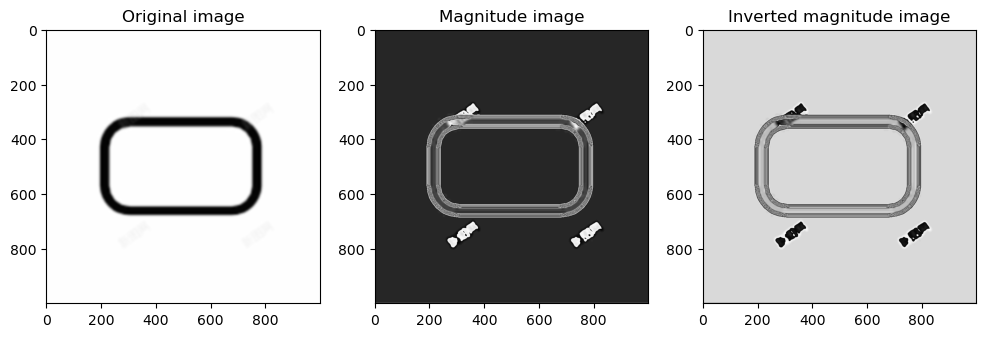

In [6]:
image = read_img('rectangle.png')
gaussian_image = cv2.GaussianBlur(image, (101, 101), 4)

x_filter = np.array([[-1, -1, -1]])
y_filter = (np.array([[1, 1, 1]]).T)
convolution_x = Convolve(gaussian_image, x_filter)
convolution_y = Convolve(gaussian_image, y_filter)
magnitude_image = getMagnitude(convolution_x, convolution_y)
inverted_magnitude_image = 255-magnitude_image

fig, axs = plt.subplots(1, 3, figsize=(12, 12))

axs[0].imshow(gaussian_image, cmap="gray")
axs[0].set_title("Original image")
axs[1].imshow(magnitude_image, cmap="gray")
axs[1].set_title("Magnitude image")
axs[2].imshow(inverted_magnitude_image, cmap="gray")
axs[2].set_title("Inverted magnitude image")
fig.savefig('result3_1.png')

In [7]:
def create_snake(center_x, center_y, radius, num_pts):
    samples = np.linspace(0, 2*math.pi, num_pts)
    snake = np.zeros((num_pts, 2))
    snake[:, 0] = np.round(radius * np.cos(samples) + center_x)
    snake[:, 1] = np.round(radius * np.sin(samples) + center_y)
    return snake[:snake.shape[0], 0], snake[:snake.shape[0], 1]

In [8]:
snake_contour_x, snake_contour_y = create_snake(500, 500, 400, 20)

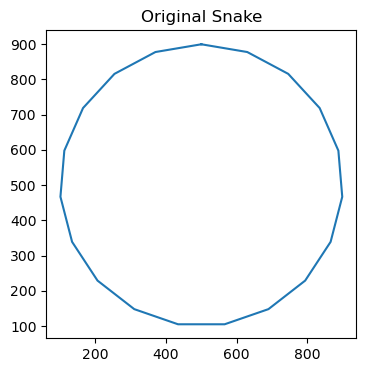

In [10]:
xx, yy = (snake_contour_x.copy(), snake_contour_y.copy())
plt.figure(figsize=(4, 4))
plt.plot(yy, xx)
plt.title("Original Snake")
plt.savefig('result3_2.png')
plt.show()

In [11]:
def get_average_distance(distances):
    total = 0
    for i in range(len(distances[0])-1):
        x1 = distances[0][i]
        x2 = distances[0][i+1]
        y1 = distances[1][i]
        y2 = distances[1][i+1]
        temp = math.sqrt((x2-x1)**2 + (y2-y1)**2)
        total += temp
    average_distance = total / len(distances[0])
    return average_distance

In [12]:
def get_points_patch(point):
    temp_x, temp_y = (-1, -1)
    points_patch_x = []
    points_patch_y = []
    for i in range(3):
        temp_y = -1
        for j in range(3):
            points_patch_x.append(point[0]+temp_x)
            points_patch_y.append(point[1]+temp_y)
            temp_y += 1
        temp_x += 1
    return np.array(points_patch_x), np.array(points_patch_y)

In [13]:
def get_image_patch(point, image):
    image_patch = np.zeros((3, 3))
    temp_x, temp_y = (-1, -1)
    for i in range(image_patch.shape[0]):
        temp_y = -1
        for j in range(image_patch.shape[1]):
            if (((point[0]+temp_x) >= image.shape[0]) or ((point[1]+temp_y) >= image.shape[1])):
                continue
            image_patch[i][j] = image[int(point[0]+temp_x)][int(point[1]+temp_y)] 
            temp_y += 1
        temp_x += 1
    return image_patch

In [14]:
def energy(avg_cor, patch, point_x, point_y, points_x, points_y, alpha, beta, gamma, current, prev_point, next_point):
    # First task: calculate external energy
    external_energy = -sum(sum(patch))
    
    # Second task: calculate internal energy
    x1 = points_x[prev_point]
    x2 = point_x
    y1 = points_y[prev_point]
    y2 = point_y
    temp1 = math.sqrt((x2-x1)**2 + (y2-y1)**2)
    vs = (avg_cor - temp1)**2
    
    temp2 = points_x[prev_point] - point_x + points_x[next_point] - point_x
    temp3 = points_y[prev_point] - point_y + points_y[next_point] - point_y
    vss = temp2**2 + temp3**2
    
    E = alpha*vs + beta*vss + gamma*external_energy
    return E, current

In [15]:
def snake_iter(image, x, y, alpha, beta, gamma, iterations):
    x_filter = np.array([[-1, -1, -1]])
    y_filter = (np.array([[1, 1, 1]]).T)
    convolution_x = Convolve(image, x_filter)
    convolution_y = Convolve(image, y_filter)
    magnitude_image = getMagnitude(convolution_x, convolution_y)
    
    for epoch in range(iterations):
        point_count, n_points = (len(x)-1, len(x))
        for i in range(n_points):
            avg_cur = get_average_distance([x, y])
            prev_point = point_count % n_points
            current = (point_count+1) % n_points
            next_point = (point_count+2) % n_points
            point_count += 1
            patch_point_x, patch_point_y = get_points_patch(np.array([x[i], y[i]]))
            Energy_score = []
            for p in range(patch_point_x.shape[0]):
                image_patch = get_image_patch(np.array([patch_point_x[p], patch_point_y[p]]), magnitude_image)
                Energy, current = energy(avg_cur, image_patch, int(patch_point_x[p]), int(patch_point_y[p]), x, y, alpha, beta, gamma, current, prev_point, next_point)
                Energy_score.append(Energy)
            min_val, min_idx = min((val, idx) for (idx, val) in enumerate(Energy_score))
            x[current] = patch_point_x[min_idx]
            y[current] = patch_point_y[min_idx]
    
    return x, y

In [16]:
# epoches = 1000
epoches = 250
alpha, beta, gamma = (0.08, 0.01, 0.5)

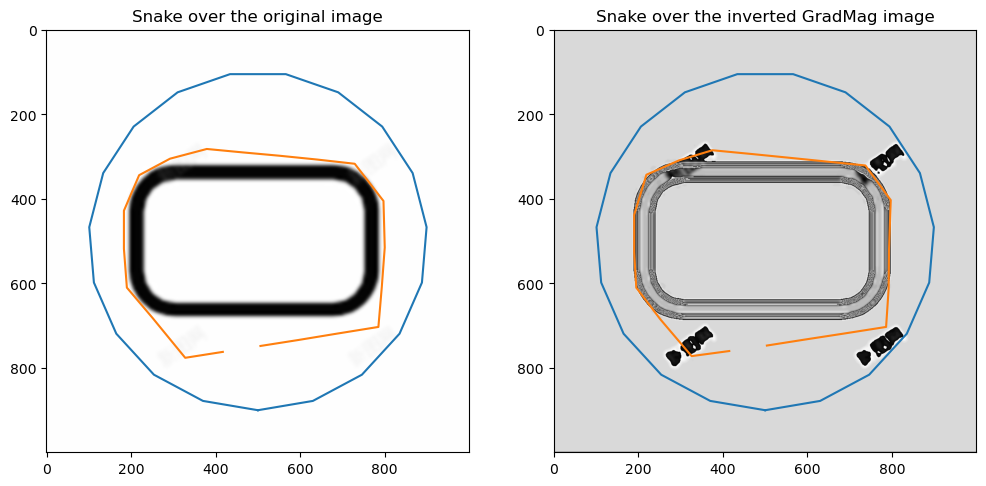

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 12))

new_snake_x, new_snake_y = snake_iter(gaussian_image, snake_contour_x, snake_contour_y, alpha, beta, gamma, epoches)
axs[0].imshow(gaussian_image, cmap="gray")
axs[0].plot(yy, xx)
axs[0].plot(new_snake_y, new_snake_x)
axs[0].set_title("Snake over the original image")

new_snake_x, new_snake_y = snake_iter(inverted_magnitude_image, snake_contour_x, snake_contour_y, alpha, beta, gamma, epoches)
axs[1].imshow(inverted_magnitude_image, cmap="gray")
axs[1].plot(yy, xx)
axs[1].plot(new_snake_y, new_snake_x)
axs[1].set_title("Snake over the inverted GradMag image")

plt.show()
fig.savefig('result3_3.png')